# Tuning Noise Models for Better Simulation Accuracy

### Overview
We go deeper into the noise model used in our simulations. By adjusting parameters such as relaxation times and depolarization probabilities, this notebook explores how fine-tuning noise can help align noisy outputs with ideal expectations.

### Goals
- Build custom noise models using Qiskit Aer.
- Systematically vary noise parameters.
- Analyze the effect of each configuration on the output distribution.


[✓] Plot saved to: ../outputs/Derivable4c/ideal_vs_noisy_exponential.png


<Figure size 640x480 with 0 Axes>

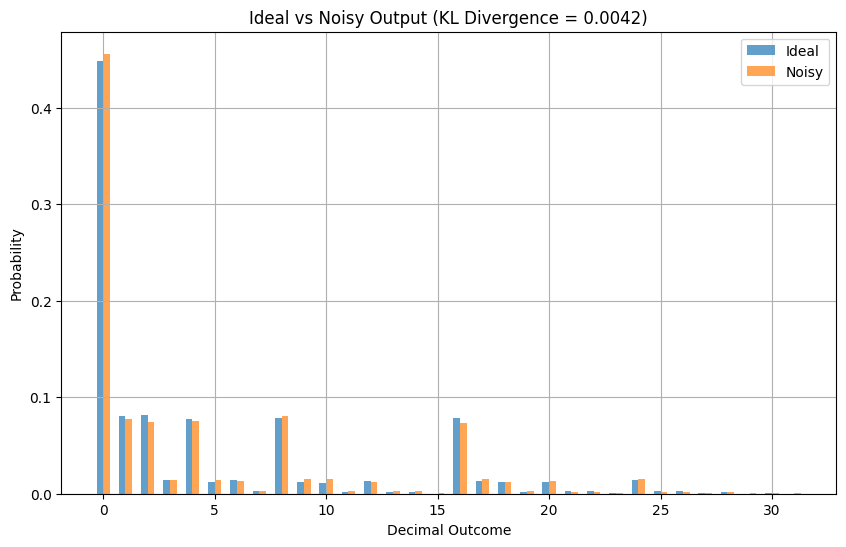

In [2]:
# Standard Imports
# ----------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import entropy  # KL divergence

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

%matplotlib inline

import os
# Create output directory
output_dir = "../outputs/Derivable4c/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist

# -------------------------------------------------------
# Exponential function and circuit
# -------------------------------------------------------
def exponential_func(x, a, b):
    return a * np.exp(-b * x)

def build_biased_quantum_walk(n_layers, theta=np.pi/4):
    qr = QuantumRegister(n_layers)
    cr = ClassicalRegister(n_layers)
    qc = QuantumCircuit(qr, cr)

    for i in range(n_layers):
        qc.ry(theta, qr[i])

    qc.barrier()
    qc.measure(qr, cr)
    return qc

# -------------------------------------------------------
# Helper: Convert counts to probabilities
# -------------------------------------------------------
def counts_to_probs(counts, n_layers):
    total = sum(counts.values())
    probs = np.zeros(2**n_layers)
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        probs[index] = count / total
    return probs

# -------------------------------------------------------
# Step 1: Define a basic noise model
# -------------------------------------------------------
def create_basic_noise_model():
    noise_model = NoiseModel()

    # Depolarizing error for single-qubit gates
    dep_error = depolarizing_error(0.01, 1)
    # Thermal relaxation error for readout
    t1 = 100e3   # coherence time (µs)
    t2 = 80e3
    gate_time = 50  # gate time (ns)
    thermal_error = thermal_relaxation_error(t1, t2, gate_time)

    # Apply to all qubits
    noise_model.add_all_qubit_quantum_error(dep_error, ['ry'])
    noise_model.add_all_qubit_quantum_error(thermal_error, ['measure'])

    return noise_model

# -------------------------------------------------------
# Step 2: Run simulation (ideal or noisy)
# -------------------------------------------------------
def run_simulation(n_layers, theta, shots=8192, noisy=False):
    qc = build_biased_quantum_walk(n_layers, theta)
    simulator = AerSimulator(noise_model=create_basic_noise_model()) if noisy else AerSimulator()
    transpiled = transpile(qc, simulator)
    result = simulator.run(transpiled, shots=shots).result()
    return result.get_counts()

# -------------------------------------------------------
# Step 3: Compare distributions using KL Divergence
# -------------------------------------------------------
def compare_distributions(probs_ideal, probs_noisy):
    # Add small epsilon to avoid log(0) errors
    epsilon = 1e-10
    probs_ideal += epsilon
    probs_noisy += epsilon

    kl_div = entropy(probs_ideal, probs_noisy)
    return kl_div

# -------------------------------------------------------
# Step 4: Plot Ideal vs Noisy Distributions
# -------------------------------------------------------
def plot_ideal_vs_noisy(ideal_counts, noisy_counts, n_layers, save_path=None):
    x = np.arange(2**n_layers)
    ideal_probs = counts_to_probs(ideal_counts, n_layers)
    noisy_probs = counts_to_probs(noisy_counts, n_layers)

    kl = compare_distributions(ideal_probs, noisy_probs)

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.15, ideal_probs, width=0.3, label='Ideal', alpha=0.7)
    plt.bar(x + 0.15, noisy_probs, width=0.3, label='Noisy', alpha=0.7)
    plt.xlabel("Decimal Outcome")
    plt.ylabel("Probability")
    plt.title(f"Ideal vs Noisy Output (KL Divergence = {kl:.4f})")
    plt.legend()
    plt.grid(True)

    # Save the plot if path provided
    if save_path:
        plt.savefig(save_fig)
    plt.show()

    # Save the figure
    # save_path = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/ideal_vs_noisy_exponential.png"
    # plt.savefig(save_path)
    # print(f"[✓] Plot saved to: {save_path}")
    # plt.show()

# -------------------------------------------------------
# Final: Run and Compare
# -------------------------------------------------------
steps = 5
theta = np.pi / 4
shots = 8192

# Run both simulations
ideal_counts = run_simulation(n_layers=steps, theta=theta, shots=shots, noisy=False)
noisy_counts = run_simulation(n_layers=steps, theta=theta, shots=shots, noisy=True)

# Plot and compare
plot_path = os.path.join(output_dir, "ideal_vs_noisy_exponential.png")
plt.savefig(plot_path, dpi=300)
print(f"[✓] Plot saved to: {plot_path}")

plot_ideal_vs_noisy(ideal_counts, noisy_counts, n_layers=steps)
